In [19]:
import numpy as np
import pandas as pd
import obspy
from obspy import UTCDateTime
import obspy.signal.filter
import sys           
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import glob
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [284]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('../../MtStHelens_activity/mt_st_helens_activity.txt', header=1, skiprows=9)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)
df_activity

,activity
UTC,
2004-09-23 09:00:00,s
2004-09-25 19:00:00,q
2004-09-26 00:00:00,c
2004-09-29 00:00:00,q
2004-10-01 19:02:00,a
2004-10-02 19:14:00,a
2004-10-02 19:14:00,t
2004-10-03 09:50:00,t
2004-10-03 11:30:00,et


# All Stations

In [8]:
def zsc(s):
    # log transform data
    log_s = np.log10(s).replace([np.inf, -np.inf], np.nan).dropna()
    
    # compute mean/std/min
    mn = np.mean(log_s)
    std = np.std(log_s)
    minzsc = np.min(log_s)                                                    

    # Calculate percentile
    s=(np.log10(s)-mn)/std
    s=s.fillna(minzsc)
    s=10**s
    return s

def zsc2(s):
    s=zsc(s)
    s=s.rolling(window=2).min()
    s[0]=s[1]
    return s

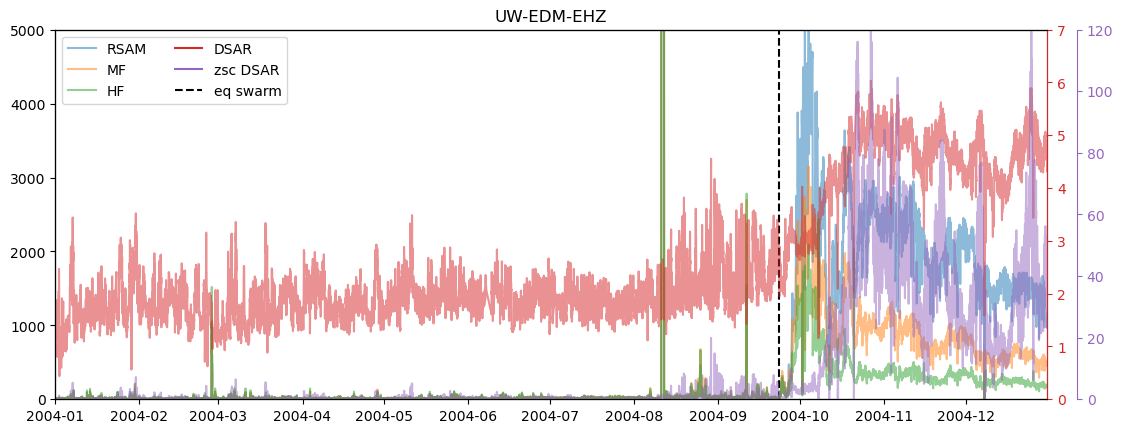

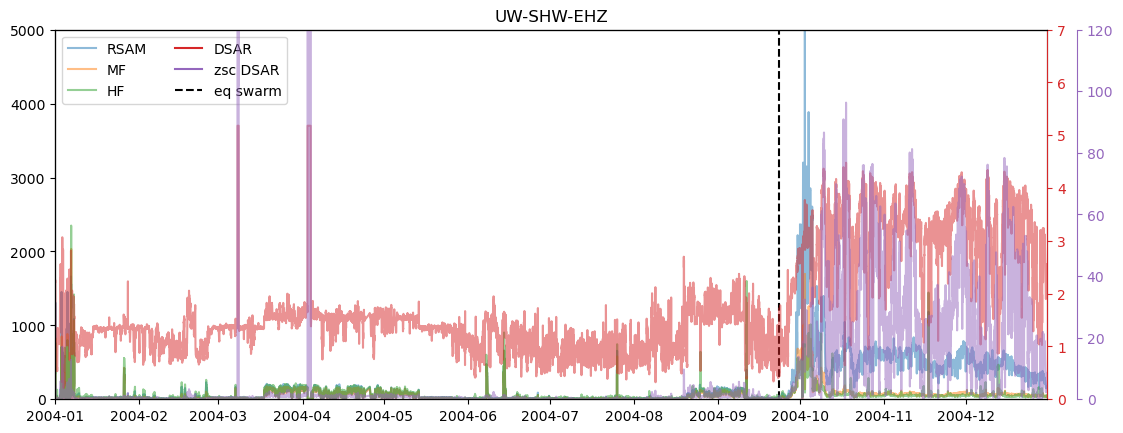

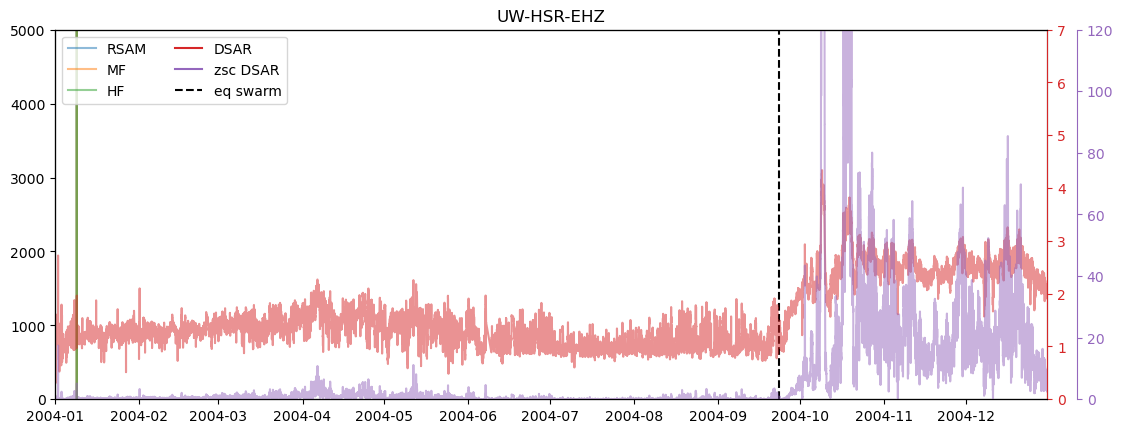

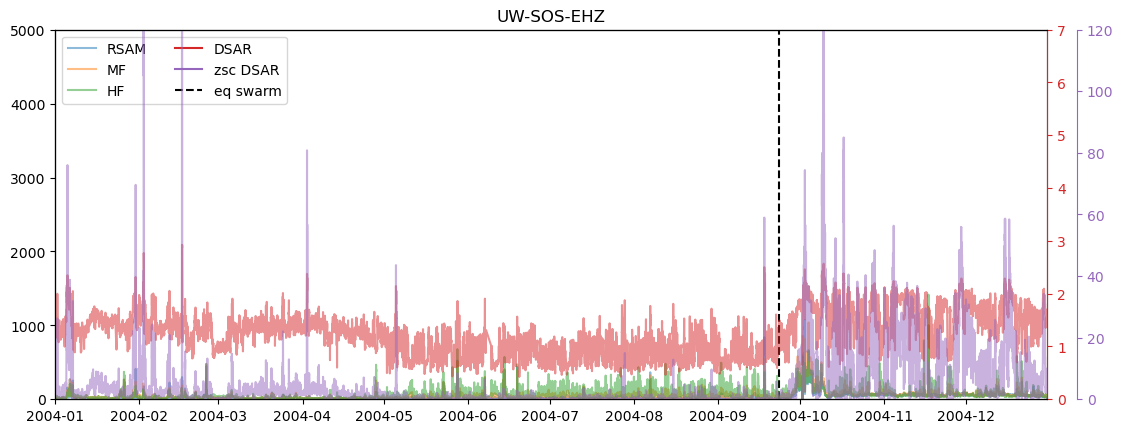

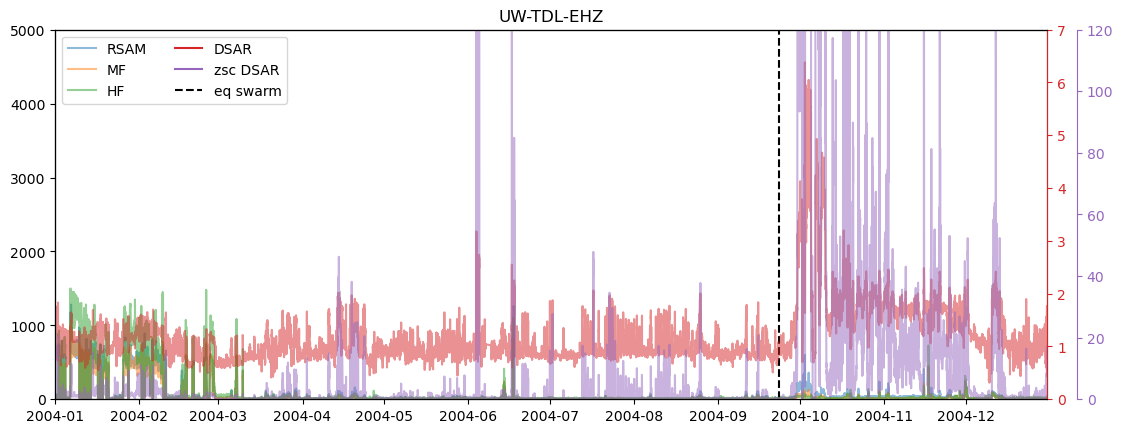

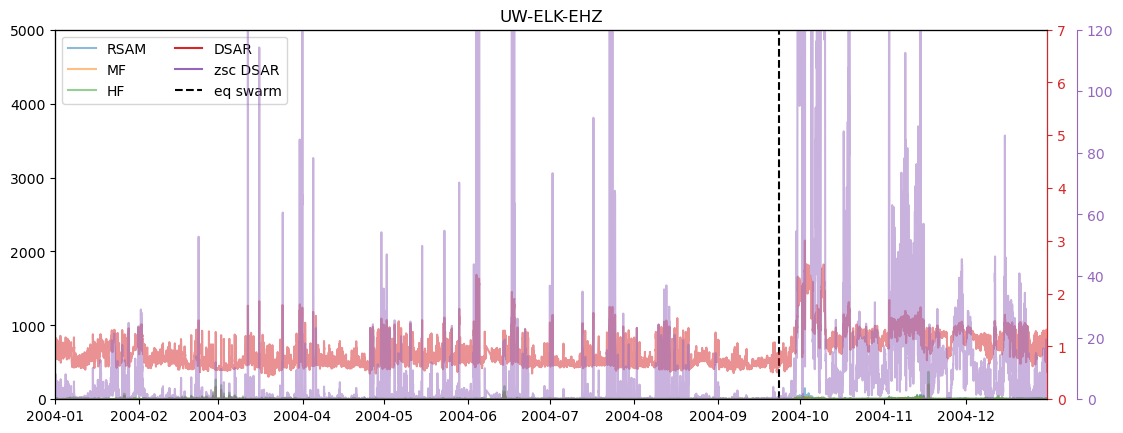

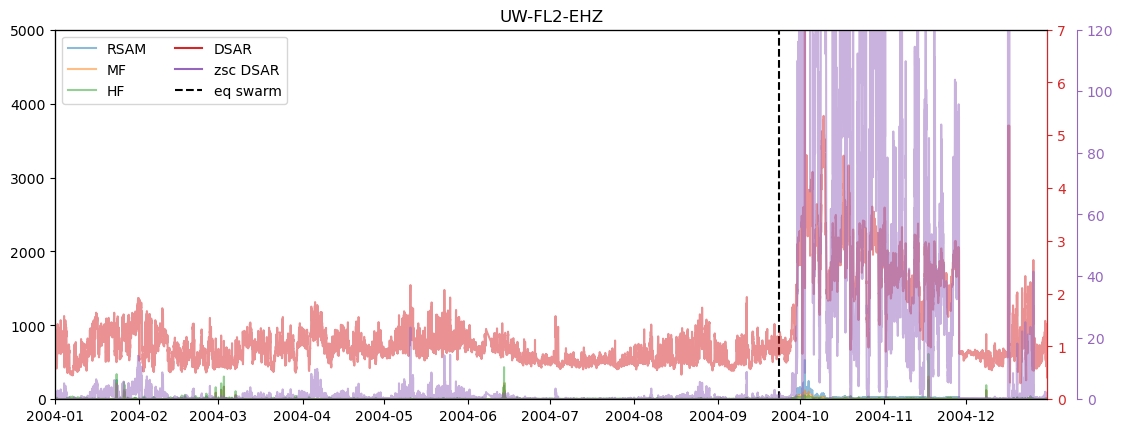

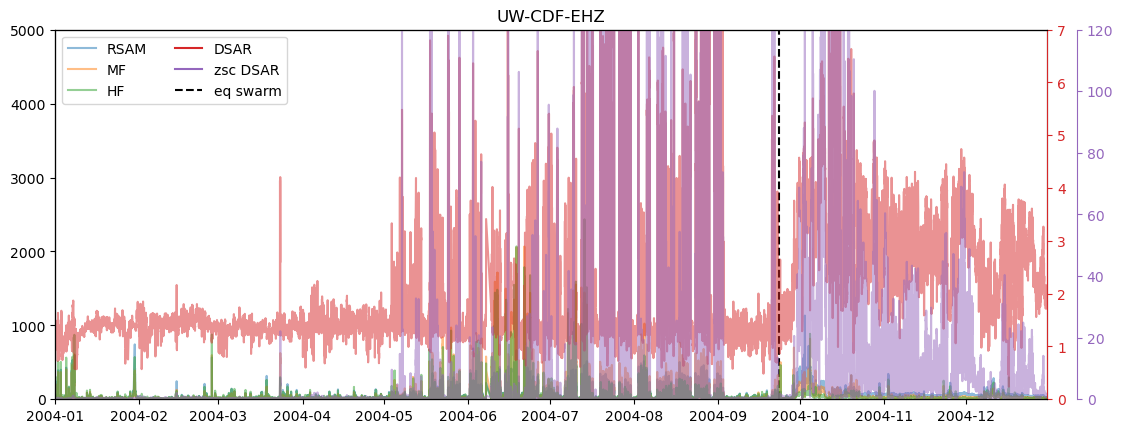

In [12]:
for sta in ['EDM','SHW','HSR','SOS','TDL','ELK','FL2','CDF']:
#     all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/{}/*.csv'.format(sta)))
#     li = []
#     for filename in all_files:
#         frame = pd.read_csv(filename)
#         li.append(frame)

#     df = pd.concat(li, axis=0, ignore_index=True)
#     df.set_index('time',inplace=True)
#     df.index = pd.to_datetime(df.index).tz_localize(None)
#     df.sort_index()

#     # compute transforms and save
#     df['zsc2_rsam'] = zsc2(df['rsam'])
#     df['zsc2_mf'] = zsc2(df['mf'])
#     df['zsc2_hf'] = zsc2(df['hf'])
#     df['zsc2_dsar'] = zsc2(df['dsar'])

#     df.to_csv('../{}_extended.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')
    
    
    df = pd.read_csv('../{}_extended.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.rolling('1H', center=True).median()
    # df = df.resample('1H').median()

    fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))

    ax.plot(df['rsam'], label='RSAM', alpha=0.5)
    ax.plot(df['mf'], label='MF', alpha=0.5)
    ax.plot(df['hf'], label='HF', alpha=0.5)
    ax.plot(np.nan, label='DSAR')
    ax.plot(np.nan, label='zsc DSAR')
    ax.plot(np.nan, label='eq swarm', color='k',linestyle='--')
    ax.set_ylim(0,5e3) # linear
    # ax.set_ylim(1e-2,1e4) # log
    # ax.set_yscale('log')

    ax2 = ax.twinx()
    ax2.spines.right.set_color('C3')
    ax2.tick_params(axis='y', colors='C3')
    ax2.tick_params(axis='y', colors='C3')
    ax2.plot(df['dsar'], label='DSAR', color='C3', alpha=0.5)
    ax2.set_ylim(0,7)

    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.03))
    ax3.spines.right.set_color('C4')
    ax3.tick_params(axis='y', colors='C4')
    ax3.tick_params(axis='y', colors='C4')
    ax3.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
    ax3.set_ylim(0,120)

    ax.set_xlim(df.index[0], df.index[-1])
    ax.vlines(UTCDateTime('2004-09-23T09:00:00'),ax.get_ylim()[0],ax.get_ylim()[-1], 'k','--')

    ax.set_title('UW-{}-EHZ'.format(sta))
    ax.legend(ncol=2, loc='upper left')
    fig.show()